Strategia inwestycyjna (decyzje wejścia i wyjścia) dla spółki  Amazon (AMZN), 

test w okresie od 01.01.2024 - 06.05.2024



Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników

4 pkt z oceny będą zależne od wyników inwestycji

Inwestujesz w wylosowaną spółkę przez określony okres, ale można wykorzystać także inne dane niż historyczne (np. obliczone wskaźniki)


In [45]:
import ffn # http://pmorissette.github.io/ffn/index.html

import yfinance as yf
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from ta.trend import MACD
import ta

from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *

import simpful as sf
from simpful import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


#### Pobranie szeregu czasowego

In [2]:
start_date = dt.datetime(2019,1,1) # (RRR-MM-DD)
end_date = dt.datetime(2024,5,6)

company = 'AMZN'

data = yf.download(company,start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [7]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,1344.00,1344.00,1344.00,1344.00,1344.00,1.344000e+03
mean,130.45,132.03,128.79,130.43,130.43,7.375730e+07
std,32.23,32.50,31.87,32.14,32.14,3.354315e+07
min,73.26,76.90,73.05,75.01,75.01,1.762600e+07
25%,96.65,97.74,95.34,96.61,96.61,5.150150e+07
50%,130.96,132.41,128.95,130.57,130.57,6.434465e+07
75%,160.23,161.81,158.34,160.16,160.16,8.687058e+07
max,187.72,189.77,185.51,189.05,189.05,3.113460e+08


Spółka nie wypłacała dywidendy, więc można użyć 'Close' lub 'Adj Close'.

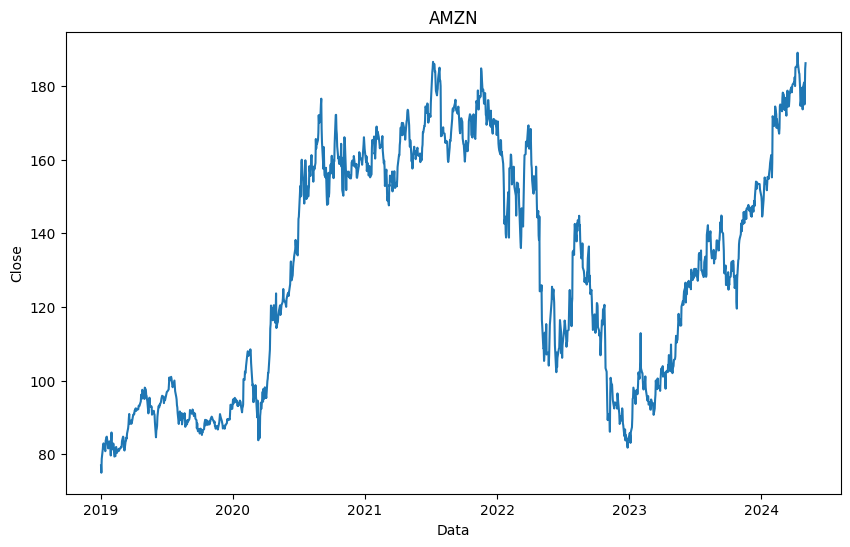

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.title(company)
plt.show()

### Dane testowe

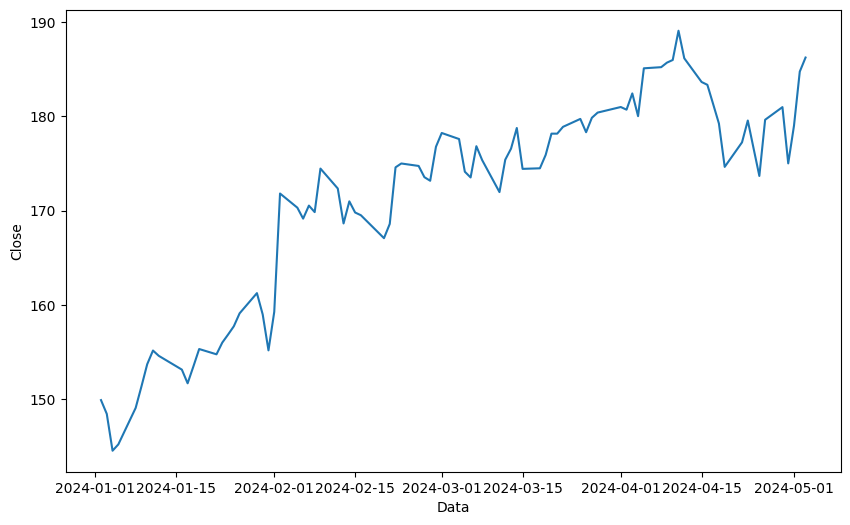

In [9]:
test_start = dt.datetime(2024,1,1) # (RRR-MM-DD)
test_end = dt.datetime(2024,5,6)

test_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]
plt.figure(figsize=(10, 6))
plt.plot(test_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

## Dane treningowe


Muszę dopytać czy obliczanie wskaźników może być na pełnym zakresie danych czy oddzielnie dla okresu testowego. Tutaj w przykładzie zrobione jest łącznie, to znaczy, że do wyliczenia wskaźników brany jest cały okres łącznie z testowym.

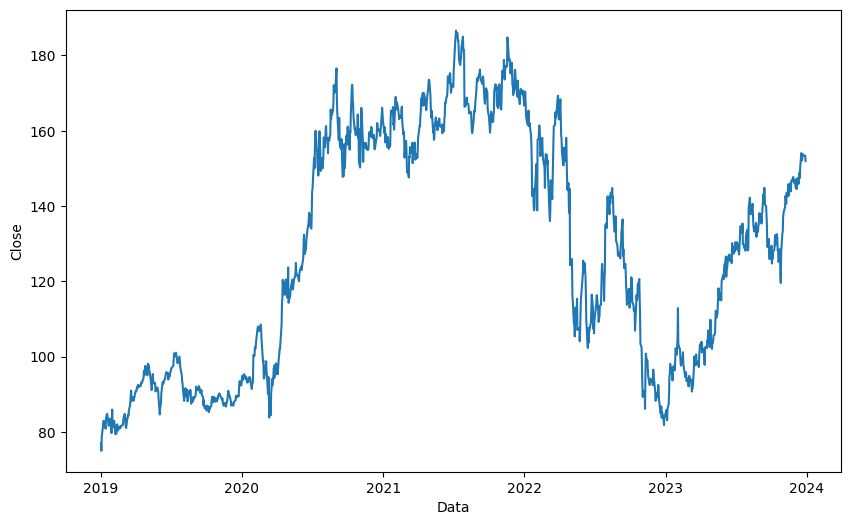

In [10]:
train_start = dt.datetime(2019,1,1)
train_end = dt.datetime(2024,1,1)

train_data = data.loc[(data.index >= train_start) & (data.index <= train_end)]
plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

### Zwroty
Używam zwrotów logarytmicznych, ponieważ są bardziej odporne na wahanai i wartości odstające.

In [11]:
data['returns'] = data['Close'].to_log_returns()
data = data.dropna()

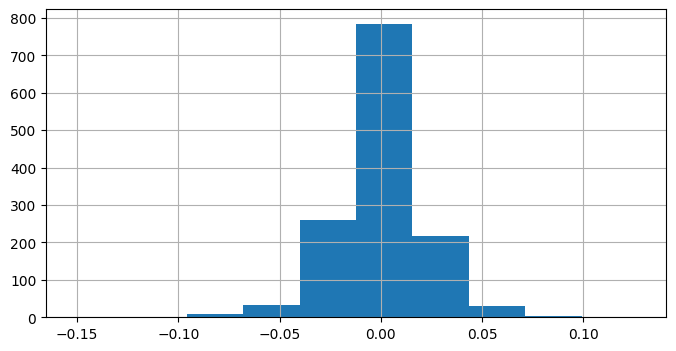

In [12]:
# rozkład zwrotów logarytmicznych
ax = data['returns'].hist(figsize=(8, 4))

#### Porównanie z indeksem NASDAQ (^IXIC)

Sprawdzenie korelacji pomiędzy spółką a głównym indeksem giełdowym

In [13]:
df = ffn.get('^IXIC:Close, AMZN:Close', start=train_start, end=train_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
returns = df.to_log_returns().dropna()
print(returns.head())

            ixicclose  amznclose
Date                            
2019-01-03  -0.030840  -0.025566
2019-01-04   0.041720   0.048851
2019-01-07   0.012477   0.033777
2019-01-08   0.010718   0.016476
2019-01-09   0.008673   0.001713


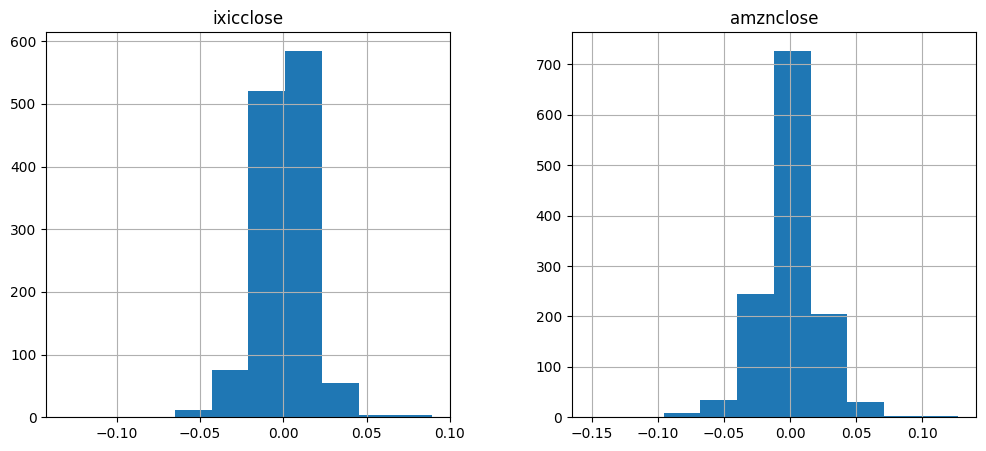

In [15]:
# porównanie zwrotów 
ax2 = returns.hist(figsize=(12, 5))

In [16]:
returns.corr().as_format('.2f')

,ixicclose,amznclose
ixicclose,1.00,0.76
amznclose,0.76,1.00


<Axes: xlabel='Date'>

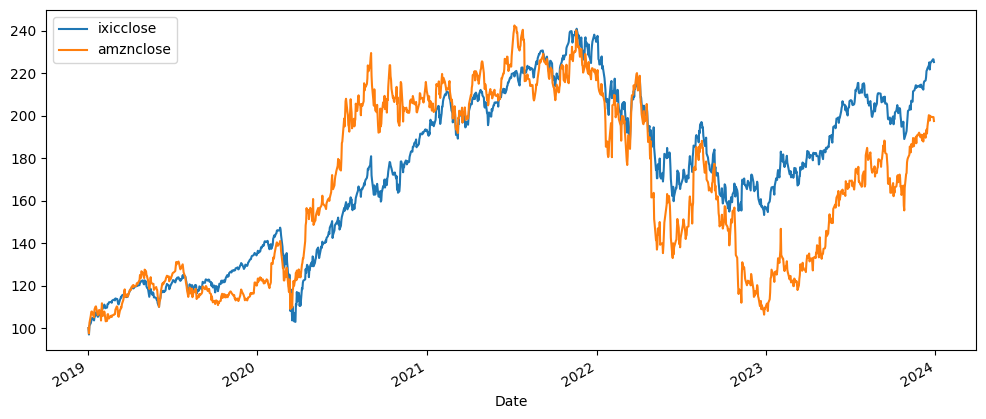

In [17]:
df.rebase().plot(figsize=(12,5))

Widać wysoką korelację pomiędzy szeregami

### Mozna to pominąć ----------

Sprawdzam zwroty mesięczne dla indeksu i spółki oraz roczny zwrot

In [37]:
perf['ixicclose'].display_monthly_returns()

  Year    Jan    Feb     Mar     Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  -----  ------  ------  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2019   9.24   3.44    2.61    4.74  -7.93   7.42   2.11  -2.6     0.46   3.66   4.5    3.54   34.6
  2020   1.99  -6.38  -10.12   15.45   6.75   5.99   6.82   9.59   -5.16  -2.29  11.8    5.65   43.64
  2021   1.42   0.93    0.41    5.4   -1.53   5.49   1.16   4      -5.31   7.27   0.25   0.69   21.39
  2022  -8.98  -3.43    3.41  -13.26  -2.05  -8.71  12.35  -4.64  -10.5    3.9    4.37  -8.73  -33.1
  2023  10.68  -1.11    6.69    0.04   5.8    6.59   4.05  -2.17   -5.81  -2.78  10.7    5.52   43.42


In [40]:
perf['amznclose'].display_monthly_returns()

  Year     Jan    Feb    Mar     Apr    May     Jun    Jul    Aug     Sep    Oct    Nov     Dec     YTD
------  ------  -----  -----  ------  -----  ------  -----  -----  ------  -----  -----  ------  ------
  2019   11.67  -4.59   8.59    8.19  -7.86    6.68  -1.42  -4.85   -2.27   2.35   1.36    2.61   20.06
  2020    8.71  -6.22   3.5    26.89  -1.28   12.96  14.71   9.05   -8.76  -3.58   4.34    2.81   76.26
  2021   -1.56  -3.53   0.04   12.07  -7.05    6.74  -3.27   4.3    -5.35   2.66   3.99   -4.93    2.38
  2022  -10.28   2.67   6.14  -23.75  -3.28  -11.65  27.06  -6.06  -10.86  -9.35  -5.76  -12.99  -49.62
  2023   22.77  -8.63   9.61    2.09  14.35    8.11   2.55   3.24   -7.89   4.7    9.77    4      80.88


Można poszukać prawidłowości ale okres obejmuje covid, więc nie wiem czy jest sens.

### Przyczynowość w sensie Grangera

In [42]:
# my_data = pd.DataFrame({'NASDAQ': returns['ixicclose'], 'AMZN': returns['amznclose']})

# # Wybór modelu VAR
# model = VAR(my_data)
# results = model.fit(maxlags=1, ic='aic')

# print(results.summary())

# # Test Ljung-Boxa
# ljung_box_nasdaq = acorr_ljungbox(results.resid['NASDAQ'])
# print(f"Ljung-Box test for NASDAQ: {ljung_box_gold}")

# ljung_box_amazn = acorr_ljungbox(results.resid['AMZN'])
# print(f"Ljung-Box test for AMZN: {ljung_box_silver}")

# # Test stabilności
# stability_test = results.test_causality('NASDAQ', 'AMZN', kind='f')
# print(stability_test.summary())

# stability_test_2 = results.test_causality('AMZN', 'NASDAQ', kind='f')
# print(stability_test_2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, May, 2024
Time:                     09:50:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.7800
Nobs:                     1256.00    HQIC:                  -16.7953
Log likelihood:           6994.89    FPE:                5.03351e-08
AIC:                     -16.8046    Det(Omega_mle):     5.00955e-08
--------------------------------------------------------------------
Results for equation NASDAQ
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000788         0.000442            1.784           0.074
L1.NASDAQ        -0.260339         0.042980           -6.057           0.000
L1.AMZN           0.095471         0.030821            3.098           0.00

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


L1.NASDAQ: -0.207284 (p = 0.001) - opóźniona wartość NASDAQ ma negatywny i statystycznie istotny wpływ na bieżącą wartość AMZN.

### ------- Koniec pominięcia

## Podział na dane testowe i treningowe
#### Przygotowanie danych pod deep learning
Można zastosowac różne modele. Ja wybrałam sobie LSTM (testowałam xgboost ale słaby)

In [18]:
# Wybór danych testowych i treningowych
train_data = data[(data.index >= train_start) & (data.index <= train_end)]
test_data = data[(data.index >= test_start) & (data.index <= test_end)]

# Przygotowanie danych
prices_train = train_data["Close"].values.reshape(-1, 1)  # konwersja do tablicy numpy
prices_test = test_data["Close"].values.reshape(-1, 1)

# Przeskalowanie do zakresu [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(prices_train)
scaled_prices_test = scaler.transform(prices_test)

# Tworzenie sekwencji danych dla modelu LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10 # ile dni bierzemy pod uwagę do predykcji

# Utworzenie sekwencji danych treningowych i testowych
X_train, y_train = create_sequences(scaled_prices_train, sequence_length)
X_test, y_test = create_sequences(scaled_prices_test, sequence_length)

print("Rozmiar danych treningowych:", X_train.shape, y_train.shape)
print("Rozmiar danych testowych:", X_test.shape, y_test.shape)

Rozmiar danych treningowych: (1247, 10, 1) (1247, 1)
Rozmiar danych testowych: (76, 10, 1) (76, 1)


## LSTM

In [19]:
# Model LSTM z hiperparametryzacją
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM
lstm_model = create_lstm_model(input_shape)

# Trenowanie
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predykcja cen dla danych testowych
predicted_prices = lstm_model.predict(X_test)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1368 - val_loss: 0.0024
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9533e-04 - val_loss: 5.8902e-04
Epoch 69/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8053e-04 - val_loss: 5.8331e-04
Epoch 70/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 6.0017e-04
Epoch 71/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5957e-04 - val_loss: 6.1275e-04
Epoch 72/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1344e-04 - val_loss: 6.2909e-04
Epoch 73/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4809e-04 - val_loss: 6.2917e-04
Epoch 74/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5880e-04 - val_loss: 6.0218e-04
Epoch 75/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8058e-04 - val_loss: 5.5770e-04
Epoch 76/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2356e-04 - val_loss: 5.6714e-04
Epoch 77/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 7.1061e-04
Epoch 78/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 5.

In [20]:
mse = mean_squared_error(y_test, predicted_prices)
print("Mean Squared Error (MSE) na danych testowych:", mse.round(5))

Mean Squared Error (MSE) na danych testowych: 0.00083


In [21]:
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices)

## 3 sposoby tworzenia sygnałów:


<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExejZ5MHlxcG80ZnpxcHdqc2I2a3VoYWxjcm8xdDdneXp2bWYzMm1xeiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/L3c8aAACw7Qpx2ojGB/giphy.gif" width="400" align="center">



Na samych predykcjach modelu LSTM najlepiej wypada opcja 3
### 1.

Najmniej 'realna'

Jeśli przewidywana cena jest wyższa niż rzeczywista cena zamknięcia, generowany jest sygnał kupna (1). W przeciwnym razie generowany jest sygnał sprzedaży (-1)

In [22]:
# Dodanie przewidywanych cen do testowych danych
test_data['Predicted_Close'] = np.nan
test_data['Predicted_Close'].iloc[sequence_length:] = predicted_prices_unscaled.flatten()

# Tworzenie sygnałów
test_data['Signal'] = 0
test_data['Signal'][sequence_length:] = np.where(test_data['Predicted_Close'][sequence_length:] > test_data['Close'][sequence_length:], 1, -1)


### 2.
Porównujemy predykcję na jutro z dzisiejszą ceną zamknięcia

Jeśli tomorrow_predicted_close > today_close, ustawiamy test_data['Signal'].iloc[i + 1] = 1 (sygnał kupna).

Jeśli tomorrow_predicted_close < today_close, ustawiamy test_data['Signal'].iloc[i + 1] = -1 (sygnał sprzedaży).

W przeciwnym razie, test_data['Signal'].iloc[i + 1] = 0 (brak zmiany).

In [36]:
test_data['Signal'] = 0

for i in range(sequence_length, len(test_data) - 1):
    today_close = test_data['Close'].iloc[i]
    tomorrow_predicted_close = test_data['Predicted_Close'].iloc[i + 1]
    
    if tomorrow_predicted_close > today_close:
        test_data['Signal'].iloc[i + 1] = 1  # Kup
    elif tomorrow_predicted_close < today_close:
        test_data['Signal'].iloc[i + 1] = -1  # Sprzedaj
    else:
        test_data['Signal'].iloc[i + 1] = 0  # Brak zmiany


### 3. To samo co 2. tylko porównanie ceny dzisiaj z predykcją za 5 dni (można dowolną liczbe wstawić)

In [37]:
test_data['Signal'] = 0

# Przewidywane ceny zamknięcia za 5 dni
future_predicted_close = test_data['Predicted_Close'].shift(-5)

for i in range(sequence_length, len(test_data) - 5):  # zmiana z len(test_data) - 1 na len(test_data) - 5
    today_close = test_data['Close'].iloc[i]
    tomorrow_predicted_close = future_predicted_close.iloc[i]
    
    if tomorrow_predicted_close > today_close:
        test_data['Signal'].iloc[i + 5] = 1  # Kup
    elif tomorrow_predicted_close < today_close:
        test_data['Signal'].iloc[i + 5] = -1  # Sprzedaj
    else:
        test_data['Signal'].iloc[i + 5] = 0  # Brak zmiany


# Wskaźniki analizy technicznej - można dowolne wybrać z bibliotegi ta

https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#momentum-indicators


Grupy:
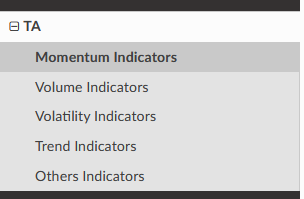

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExc2U1a3ZkdTFjaWFkOXc0dGl2bTQ3dHI1b2xwNG9kcnhxNG03d2M5OCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3diE2vbIarCXWXaN15/giphy.gif" width="400" align="center">


Wskaźniki liczę na testowym dataframe ze względu małą liczbę danych testowych <- jeszcze muszę się dopytać

### MACD
przykład

In [48]:
macd_indicator = ta.trend.MACD(test_data['Close'])

# Łączenie z ramką danych
test_data['macd'] = macd_indicator.macd()
test_data['macd_signal'] = macd_indicator.macd_signal()

# Różnica potrzebna do sygnałów
test_data['macd_diff'] = test_data['macd'] - test_data['macd_signal']

# Domyśnie HOLD
test_data['signal_MACD'] = 0  

# Kupno (MACD > sygnał)
test_data.loc[test_data['macd_diff'] > 0, 'signal_MACD'] = 1

# Sprzedaż (MACD < sygnał)
test_data.loc[test_data['macd_diff'] < 0, 'signal_MACD'] = -1


## Strategie

Strategia tylko na predykcjach modelem LSTM:

In [39]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.066975
    ttp = 0.060409
    size_tr = 0.878244
    def init(self):
        super().init()
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1], 
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]


Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                  10889.04556
Equity Peak [$]                  11419.438731
Return [%]                           8.890456
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   28.347898
Volatility (Ann.) [%]                21.83169
Sharpe Ratio                         1.298475
Sortino Ratio                        3.142575
Calmar Ratio                         6.103342
Max. Drawdown [%]                   -4.644652
Avg. Drawdown [%]                   -1.762132
Max. Drawdown Duration       27 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                   29
Win Rate [%]                        44.827586
Best Trade [%]                       7.583499
Worst Trade [%]                     -6.224001
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.024120  0.039645  0.994793    14117.873527
0.023308  0.039677  0.989044    14754.980989
0.023364  0.038662  0.990048    14774.892750
Name: Equity Final [$], dtype: float64

In [40]:
stats_skopt

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                  14774.89275
Equity Peak [$]                   14774.89275
Return [%]                          47.748928
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                  213.867055
Volatility (Ann.) [%]               68.773609
Sharpe Ratio                         3.109726
Sortino Ratio                       21.563752
Calmar Ratio                        57.719712
Max. Drawdown [%]                   -3.705269
Avg. Drawdown [%]                   -1.660546
Max. Drawdown Duration       10 days 00:00:00
Avg. Drawdown Duration        5 days 00:00:00
# Trades                                   28
Win Rate [%]                        71.428571
Best Trade [%]                       5.969814
Worst Trade [%]                     -1.656835
Avg. Trade [%]                    

## Strategia z MACD

In [47]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume,returns,Predicted_Close,Signal,macd,macd_signal,macd_diff,signal
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,-0.013317,NaN,0,NaN,NaN,NaN,0
2024-01-03,149.199997,151.050003,148.330002,148.470001,148.470001,49425500,-0.009786,NaN,0,NaN,NaN,NaN,0
2024-01-04,145.589996,147.380005,144.050003,144.570007,144.570007,56039800,-0.026619,NaN,0,NaN,NaN,NaN,0
2024-01-05,144.690002,146.589996,144.529999,145.240005,145.240005,45124800,0.004624,NaN,0,NaN,NaN,NaN,0
2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100,0.026230,NaN,0,NaN,NaN,NaN,0


In [50]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.066975
    ttp = 0.060409
    size_tr = 0.878244
    
    def init(self):
        super().init()
        close_series = pd.Series(self.data.Close)  # Convert to Pandas Series
        self.macd_decision = self.I(lambda x: test_data['signal_MACD'], 'signal_MACD')
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        macd_decision = self.macd_decision
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 or macd_decision == 1 and not self.position.is_long:  
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 or macd_decision == -1 and not self.position.is_short:  
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# # Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1], 
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                 10727.800731
Equity Peak [$]                  12214.458807
Return [%]                           7.278007
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                      22.858
Volatility (Ann.) [%]               27.544688
Sharpe Ratio                         0.829851
Sortino Ratio                        1.638809
Calmar Ratio                         1.878025
Max. Drawdown [%]                  -12.171297
Avg. Drawdown [%]                   -2.529002
Max. Drawdown Duration       22 days 00:00:00
Avg. Drawdown Duration        7 days 00:00:00
# Trades                                   29
Win Rate [%]                        48.275862
Best Trade [%]                       8.737921
Worst Trade [%]                    -10.422409
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.023338  0.055370  0.999423    15729.302066
0.023355  0.040720  0.997962    15732.753217
0.023374  0.040105  0.992046    15737.599342
Name: Equity Final [$], dtype: float64

In [51]:
stats_skopt

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                 15737.599342
Equity Peak [$]                  15737.599342
Return [%]                          57.375993
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                  277.637887
Volatility (Ann.) [%]               89.343545
Sharpe Ratio                         3.107532
Sortino Ratio                       27.676696
Calmar Ratio                        80.411734
Max. Drawdown [%]                   -3.452704
Avg. Drawdown [%]                   -1.561218
Max. Drawdown Duration       10 days 00:00:00
Avg. Drawdown Duration        5 days 00:00:00
# Trades                                   33
Win Rate [%]                        75.757576
Best Trade [%]                       7.549234
Worst Trade [%]                     -1.798107
Avg. Trade [%]                    